# Custom logistic regression algorithm - initial diagnosis of chronic kidney disease

# Abstract
Using custom linear regression algorithm we take a dataset containing a list of patients with different symptoms and chronic kidney disease (CKD) and train our model to perform an initial diagnosis of CKD. We split our data in to training, validation and testing datasets. After training the model on the training data, we tune the parameters of our algorithm using our validation dataset. We also set out to detect all positive cases of CKD whilst minimising false positives. This is because an initial diagnosis is a precursor to a more rigerous diagnosis procedure. We detect 100% of positive CKD cases in our test dataset whilst identifying about 76% of negative cases. Our final performance was not ideal as 24% of false positives is quite high, however, the size of the dataset was quite small (355). However, we achieved our goal of detecting 100% of positive cases.  

# Contents
<ul>
    <li>Importing dataset</li>
    <li>Determining learning rate - convergence with linear and polynomial features</li>
    <li>Determining degree of features</li>
    <li>Reducing overfitting with reparameterisation</li>
    <li>Results</li>
</ul>

# Importing daatset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

First we import my custom logistic regression functions as a module. Writing and testing of these functions can be found in previous notebook.

In [2]:
import mylogregression as mlr

Read in dataset.

In [3]:
df = pd.read_csv('CKD_cleaned.csv')

In [4]:
df.head(3)

,age,bp,sg,al,su,pcc_present,ba_present,bgr,bu,sc,...,pcv,wc,rc,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,classification_ckd
0,48.0,80.0,1.02,1.0,0.0,0.0,0.0,121.000000,36.0,1.2,...,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.02,4.0,0.0,0.0,0.0,148.134146,18.0,0.8,...,38.0,6000.0,4.679268,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.01,2.0,3.0,0.0,0.0,423.000000,53.0,1.8,...,31.0,7500.0,4.679268,0.0,1.0,0.0,1.0,0.0,1.0,1


Sort data in to features and target features.

In [5]:
X = df.drop(labels="classification_ckd",axis=1)
y = df["classification_ckd"]

Apply scaling to features.

In [6]:
X = mlr.min_max_scale(X)
X.head(3)

,age,bp,sg,al,su,pcc_present,ba_present,bgr,bu,sc,...,hemo,pcv,wc,rc,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,0.505882,0.230769,0.75,0.2,0.0,0.0,0.0,0.211538,0.088575,0.010582,...,0.836735,0.777778,0.231405,0.525424,1.0,1.0,0.0,0.0,0.0,0.0
1,0.023529,0.000000,0.75,0.8,0.0,0.0,0.0,0.269517,0.042362,0.005291,...,0.557823,0.644444,0.157025,0.437164,0.0,0.0,0.0,0.0,0.0,0.0
2,0.670588,0.230769,0.25,0.4,0.6,0.0,0.0,0.856838,0.132221,0.018519,...,0.442177,0.488889,0.219008,0.437164,0.0,1.0,0.0,1.0,0.0,1.0


Split dataset in to testing, validation and testing datasets.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.5)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5)

# Determining learning rate - convergence with linear and polynomial features

Lets test convergence using linear features for several different leaning rates.

In [8]:
alpha_lst = [.1, .3, 1, 3, 10]
iterations_history, cost_reg_history = [], []
N_train = len(X_train.columns)
W_init, b_init = np.ones(N_train).reshape(N_train,1), 0.
lambda_ = 0.
max_iter_val = 3000
for alpha_val in alpha_lst:
    cost_reg, dummy_W, dummy_b, iterations, final_cost = mlr.gradient_descent(X_train, y_train, W_init, b_init, lambda_, alpha=alpha_val, max_iter=max_iter_val, print_step=False, save_step=1)
    cost_reg_history.append(cost_reg)
    iterations_history = iterations
    print("alpha={} complete.".format(alpha_val))

alpha=0.1 complete.
alpha=0.3 complete.
alpha=1 complete.
alpha=3 complete.
alpha=10 complete.


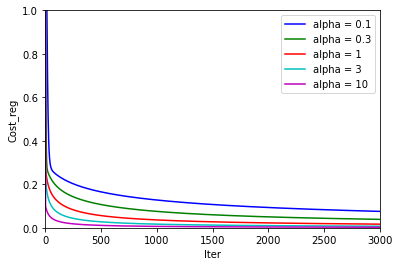

In [9]:
colour = ['b','g','r','c','m']
for i in range(len(colour)):
    plt.plot(iterations_history,cost_reg_history[i], color=colour[i], label='alpha = {}'.format(alpha_lst[i]))
plt.ylabel("Cost_reg")
plt.xlabel("Iter")
plt.axis([0, 3000, 0, 1])
plt.legend()

We see that convergence is reliably reached by setting alpha = 3 with about 3000 iterations.

# Determining degree of features

Lets check convergence when we add higher power polynomial features with our chosen learning rate and iterations.

In [10]:
degree_lst = [1,2,3,4,5,10]
iterations_history, cost_reg_history = [], []
b_init = 0.
lambda_ = 0.
alpha_val = 3
max_iter_val = 3000
for degree_val in degree_lst:
    X_train_poly = mlr.encode_polynomial(X_train, degree=degree_val)
    X_train_poly = mlr.min_max_scale(X_train_poly)
    N_train_poly = len(X_train_poly.columns)
    W_init = np.ones(N_train_poly).reshape(N_train_poly,1)
    cost_reg, dummy_W, dummy_b, iterations, final_cost = mlr.gradient_descent(X_train_poly, y_train, W_init, b_init, lambda_, alpha=alpha_val, max_iter=max_iter_val, print_step=False, save_step=10)
    cost_reg_history.append(cost_reg)
    iterations_history = iterations
    print("degree={} complete.".format(degree_val))

degree=1 complete.
degree=2 complete.
degree=3 complete.
degree=4 complete.
degree=5 complete.
degree=10 complete.


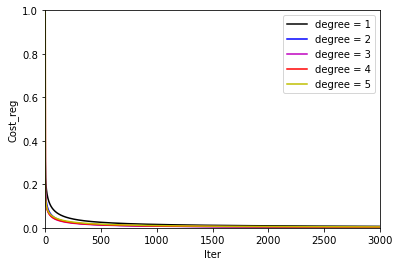

In [11]:
colour = ['k','b','m','r','y']
for i in range(len(colour)):
    plt.plot(iterations_history,cost_reg_history[i], color=colour[i], label='degree = {}'.format(degree_lst[i]))
plt.ylabel("Cost_reg")
plt.xlabel("Iter")
plt.axis([0, 3000, 0.0, 1])
plt.legend()

We reach convergence with our current learning rate and iterations.

Lets see how our cost functions (training and validation) vary with different power polynomial features. 

In [12]:
degree_vec = np.arange(1,6)
train_cost_vec, valid_cost_vec = [], []
for degree_val in degree_vec:
    dummy_y_hat, dummy_W, dummy_b, train_cost, valid_cost = mlr.logistic_regression(X_train, X_valid, y_train, y_valid, lambda_=0., degree=degree_val, alpha=3, max_iter=3000, print_step=False)
    train_cost_vec.append(train_cost)
    valid_cost_vec.append(valid_cost)
    print("degree: {} complete".format(degree_val))

degree: 1 complete
degree: 2 complete
degree: 3 complete
degree: 4 complete
degree: 5 complete


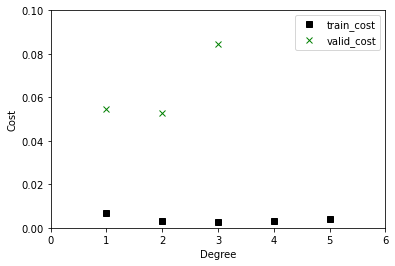

In [13]:
plt.plot(degree_vec,train_cost_vec, 'ks', label='train_cost')
plt.plot(degree_vec,valid_cost_vec, 'gx', label='valid_cost')
plt.ylabel("Cost")
plt.xlabel("Degree")
plt.axis([0, 6, 0, .1])
plt.legend()

# Reducing overfitting with reparameterisation

We see that we have overfitting, this means that our data fits our training data well but fits our validattion data worse. Lets see if we can remedy this by introducing reparameterisation.

In [26]:
degree_vec = np.arange(1,6)
train_cost_vec, valid_cost_vec = [], []
lambda_val = 0.1
for degree_val in degree_vec:
    dummy_y_hat, dummy_W, dummy_b, train_cost, valid_cost = mlr.logistic_regression(X_train, X_valid, y_train, y_valid, lambda_=lambda_val, degree=degree_val, alpha=3, max_iter=3000, print_step=False)
    train_cost_vec.append(train_cost)
    valid_cost_vec.append(valid_cost)
    print("degree: {} complete".format(degree_val))

degree: 1 complete
degree: 2 complete
degree: 3 complete
degree: 4 complete
degree: 5 complete


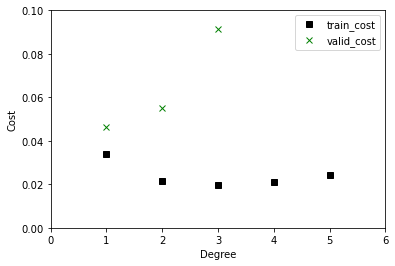

In [27]:
plt.plot(degree_vec,train_cost_vec, 'ks', label='train_cost')
plt.plot(degree_vec,valid_cost_vec, 'gx', label='valid_cost')
plt.ylabel("Cost")
plt.xlabel("Degree")
plt.axis([0, 6, 0, .1])
plt.legend()

We can see that introducing reparameterisation we can reduce the cost of our validation dataset. Now we are not overfit to our training dataset. Lets move on with the settings that most reduced our validation dataset cost: degree=1 and lambda_=0.1.

In a medical diagnosis model we would rather be safe than sorry. Meaning we would rather over diagnose as opposed to under diagnose. This is because this algorithm would be a precursor to a more invasive procedure. For this reason, we may want to predict if someone has a 10% likelihood of having CKD (f_cutoff = 0.1) or a 1% chance (f_cutoff = 0.01). But of course, a model that diagnoses everyone is usefull. So using our validation data we will try to diagnose as many people as possible whilst trying to limiting false positives.

In [28]:
#degree_vec = [1,2,3]
f_cutoff_vec = [0.001,0.003,0.01,0.03,0.1,0.5,0.9,0.97,0.99,0.997,0.999]
true_pos_det = []
true_neg_det = []
for f_cutoff_val in f_cutoff_vec:
    y_hat, dummy_W, dummy_b, train_cost, valid_cost = mlr.logistic_regression(X_train, X_valid, y_train, y_valid, lambda_=0.1, degree=1, alpha=3, f_cutoff = f_cutoff_val, max_iter=3000, print_step=False)
    true_pos = 100*sum(y_hat[y_valid==1] == y_valid[y_valid==1])/len(y_valid[y_valid==1])
    true_neg = 100*sum(y_hat[y_valid==0] == y_valid[y_valid==0])/len(y_valid[y_valid==0])
    true_pos_det.append(true_pos)
    true_neg_det.append(true_neg)
    print("f_cutoff: {} complete".format(f_cutoff_val))

f_cutoff: 0.001 complete
f_cutoff: 0.003 complete
f_cutoff: 0.01 complete
f_cutoff: 0.03 complete
f_cutoff: 0.1 complete
f_cutoff: 0.5 complete
f_cutoff: 0.9 complete
f_cutoff: 0.97 complete
f_cutoff: 0.99 complete
f_cutoff: 0.997 complete
f_cutoff: 0.999 complete


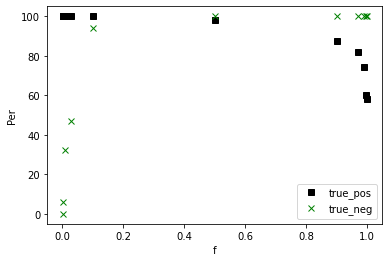

In [29]:
plt.plot(f_cutoff_vec,true_pos_det, 'ks', label='true_pos')
plt.plot(f_cutoff_vec,true_neg_det, 'gx', label='true_neg')
plt.ylabel("Per")
plt.xlabel("f")
#plt.axis([0, 3, 0.5, .8])
plt.legend()

Here we see that in our validation data, when we set f=0.1 we disgnosed 100% of true positives and only got about 5% of false positives. This seems like an acceptable result, and so we will for our test data set f_cutoff = 0.1.

# Results

Now we have picked our algorithm parameters on our validation daatset, it is time to move on to our test dataset. Lets apply our chosen parameters, alpha = 3, degree = 2, lambda_=0.3 and f_cutoff=0.1 and compare the cost of our training and test datasets.

In [30]:
y_hat, dummy_W, dummy_b, train_cost, test_cost = mlr.logistic_regression(X_train, X_test, y_train, y_test, lambda_=0.1, degree=1, alpha=3, f_cutoff = 0.1, max_iter=3000, print_step=False)
print("Train cost is {} and test cost is {}".format(train_cost,test_cost))

Train cost is 0.03416213832149927 and test cost is 0.057936583059497344


The training cost and testing cost are not too far apart which means we do not have awful overfitting (but we still have some)! This is a good sign that our reparameterisation step worked.

In [31]:
print("Custom algorithm correctly identified {}% of results.".format(100*sum(y_hat == y_test)/len(y_hat)))
print("Custom algorithm predicted {}% of positive results.".format(100*sum(y_hat[y_test==1] == y_test[y_test==1])/len(y_test[y_test==1])))
print("Custom algorithm predicted {}% of negative results.".format(100*sum(y_hat[y_test==0] == y_test[y_test==0])/len(y_test[y_test==0])))

Custom algorithm correctly identified 92.13483146067416% of results.
Custom algorithm predicted 100.0% of positive results.
Custom algorithm predicted 75.86206896551724% of negative results.


Our model predicted all positive results correctly! However, we did incorrectly diagnose about 24% of negatiive cases which is slightly high. But not bad considering the small size of the dataset!